In [1]:
#Llamamos las librerías necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Leemos los datos
df0 = pd.read_csv('vid18_180219.dat', delimiter = ',')
df0.head(2)

,TIMESTAMP,RECORD,batt_volt_Min,logger_temp,short_up_Avg,short_dn_Avg,long_up_Avg,long_dn_Avg,cnr4_T_C_Avg,cnr4_T_K_Avg,...,Result2_Avg,Result3_Avg,Result4_Avg,Result5_Avg,Result6_Avg,Result7_Avg,Result8_Avg,Result9_Avg,Riego_mm_Tot,Perco_mm_Tot
0,2018-05-11 20:10:00,7980,12.31,25.87,-5.499501,1.581859,-82.19471,-4.002829,23.26391,296.4139,...,0.04,26.4,79.5,0.041,14.71,14.75,15.09,14.45,0.0,0
1,2018-05-11 20:20:00,7981,12.30,25.37,-4.934265,1.946161,-80.00718,-1.978131,22.75189,295.9019,...,0.04,26.4,79.5,0.041,14.71,14.75,15.09,14.45,0.0,0


In [3]:
#Modificamos el DataFrame para solo tener las columnas de datos deseadas.
df0 = pd.DataFrame({"TIMESTAMP" : df0.TIMESTAMP, "TEMP" : df0.AirTC_Avg})
df0.head()

,TIMESTAMP,TEMP
0,2018-05-11 20:10:00,23.50
1,2018-05-11 20:20:00,22.96
2,2018-05-11 20:30:00,22.73
3,2018-05-11 20:40:00,22.40
4,2018-05-11 20:50:00,22.46


In [4]:
#Pasamos las variables al formato datetime y cortamos la parte superior de los datos antes del 01 de Noviembre de 2018.
df0['TIMESTAMP'] = pd.to_datetime(df0.apply(lambda x: x['TIMESTAMP'], 1), dayfirst = True)
df0 = df0[(df0["TIMESTAMP"] > "2018-11-1")]
df0.head()

,TIMESTAMP,TEMP
24936,2018-11-01 00:10:00,8.89
24937,2018-11-01 00:20:00,8.66
24938,2018-11-01 00:30:00,8.52
24939,2018-11-01 00:40:00,8.47
24940,2018-11-01 00:50:00,8.58


In [5]:
#Separamos la fecha en partes importantes.
df0['YEAR'] = df0['TIMESTAMP'].dt.year
df0['MONTH'] = df0['TIMESTAMP'].dt.month
df0['DAY'] = df0['TIMESTAMP'].dt.day
df0['HOUR'] = df0['TIMESTAMP'].dt.hour

In [6]:
#Creamos un DataFrame con los datos promediados cada hora.
dfH = df0.set_index('TIMESTAMP').resample('H').mean()
dfH.head()

,TEMP,YEAR,MONTH,DAY,HOUR
TIMESTAMP,,,,,
2018-11-01 00:00:00,8.624000,2018.0,11.0,1.0,0.0
2018-11-01 01:00:00,8.493333,2018.0,11.0,1.0,1.0
2018-11-01 02:00:00,8.690000,2018.0,11.0,1.0,2.0
2018-11-01 03:00:00,8.846667,2018.0,11.0,1.0,3.0
2018-11-01 04:00:00,7.397500,2018.0,11.0,1.0,4.0


In [7]:
#Establecemos condiciones para los valores de UF.
conditions = [
    (dfH['TEMP'] >= 1.5) & (dfH['TEMP'] <= 2.4),
    (dfH['TEMP'] >= 2.5) & (dfH['TEMP'] <= 9.1),
    (dfH['TEMP'] >= 9.2) & (dfH['TEMP'] <= 12.4),
    (dfH['TEMP'] >= 12.5) & (dfH['TEMP'] <= 15.9),
    (dfH['TEMP'] >= 16) & (dfH['TEMP'] <=18),
    (dfH['TEMP'] > 18 )
    ]

#Se crean las opciones para valores de UF.
choices = [0.5, 1.0, 0.5, 0, -0.5, -1.0]

#Se asignan los valores de UF en una nueva columna en dfH.
dfH['UF'] = np.select(conditions, choices, default = 0)
dfH.head(12)

,TEMP,YEAR,MONTH,DAY,HOUR,UF
TIMESTAMP,,,,,,
2018-11-01 00:00:00,8.624000,2018.0,11.0,1.0,0.0,1.0
2018-11-01 01:00:00,8.493333,2018.0,11.0,1.0,1.0,1.0
2018-11-01 02:00:00,8.690000,2018.0,11.0,1.0,2.0,1.0
2018-11-01 03:00:00,8.846667,2018.0,11.0,1.0,3.0,1.0
2018-11-01 04:00:00,7.397500,2018.0,11.0,1.0,4.0,1.0
2018-11-01 05:00:00,7.289833,2018.0,11.0,1.0,5.0,1.0
2018-11-01 06:00:00,6.806833,2018.0,11.0,1.0,6.0,1.0
2018-11-01 07:00:00,8.110167,2018.0,11.0,1.0,7.0,1.0
2018-11-01 08:00:00,14.960000,2018.0,11.0,1.0,8.0,0.0


In [8]:
#Creamos un DataFrame con los valores promediados cada día.
dfDAY = df0.set_index('TIMESTAMP').resample('D').mean()

#Se generan las columnas con los valores de UF24, las temperaturas máximas y mínimas por día, y el UF24 acumulado día tras día.
dfDAY['UF24'] = dfH.groupby(['YEAR','MONTH','DAY'])['UF'].transform('sum')
dfDAY['TMAX'] = df0.set_index('TIMESTAMP').resample('D')["TEMP"].max()
dfDAY['TMIN'] = df0.set_index('TIMESTAMP').resample('D')["TEMP"].min()
dfDAY['UF24-ACUM'] = dfDAY.UF24.cumsum()

In [9]:
dfDAY.drop('HOUR', axis = 1).head()

,TEMP,YEAR,MONTH,DAY,UF24,TMAX,TMIN,UF24-ACUM
TIMESTAMP,,,,,,,,
2018-11-01,16.319273,2018.0,11.0,1.0,-0.5,29.58,6.096,-0.5
2018-11-02,19.581528,2018.0,11.0,2.0,-9.0,31.35,10.020,-9.5
2018-11-03,19.061736,2018.0,11.0,3.0,-9.5,30.48,10.160,-19.0
2018-11-04,20.023194,2018.0,11.0,4.0,-11.5,31.39,11.160,-30.5
2018-11-05,19.522153,2018.0,11.0,5.0,-8.0,31.21,11.130,-38.5


Text(0.5, 1.0, 'Evolución de las temperaturas máximas y mínimas')

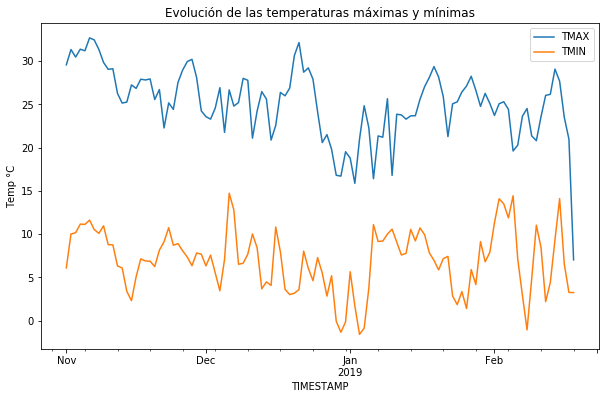

In [10]:
#Graficar la evolución de las temperaturas máxima y mínima desde el 01 de Noviembre de 2018 hasta el 18 de Febrero de 2019.
fig1 = dfDAY.reset_index().plot(x = "TIMESTAMP", y = ["TMAX", "TMIN"], figsize = (10, 6))
fig1.set_ylabel('Temp °C')
fig1.set_title("Evolución de las temperaturas máximas y mínimas")

Text(0.5, 1.0, 'Horas de frio acumuladas')

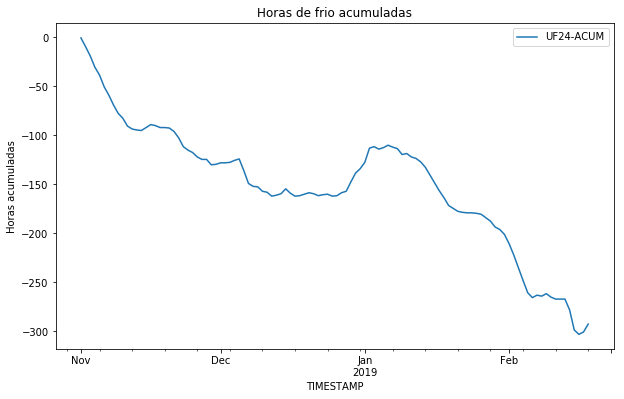

In [11]:
#Graficar la acumulación horas de frio en el periodo de estudio.
fig2 = dfDAY.reset_index().plot(x = "TIMESTAMP", y = ["UF24-ACUM"], figsize = (10, 6))
fig2.set_ylabel('Horas acumuladas')
fig2.set_title("Horas de frio acumuladas")